In [1]:
from blade_design import blade_design
import matplotlib.pyplot as plt


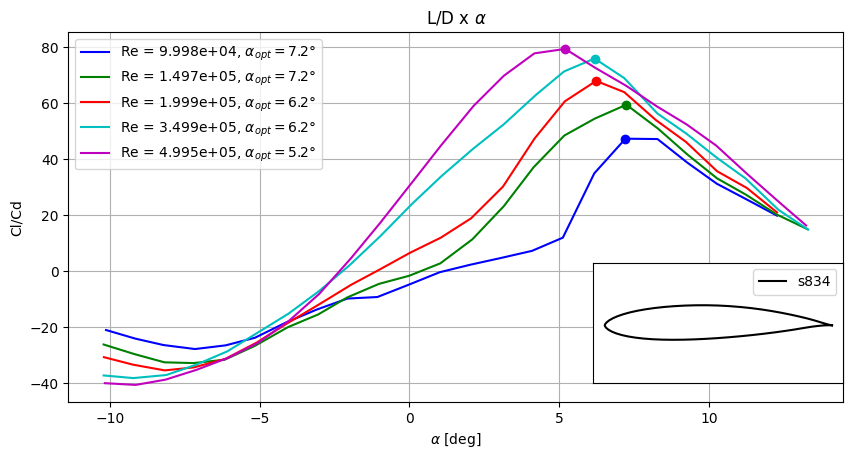

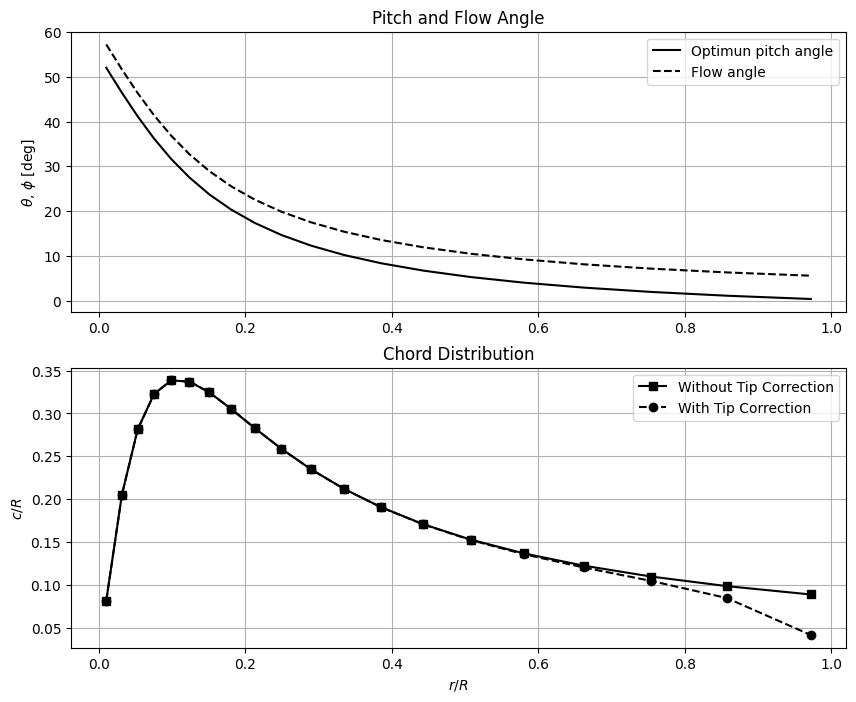

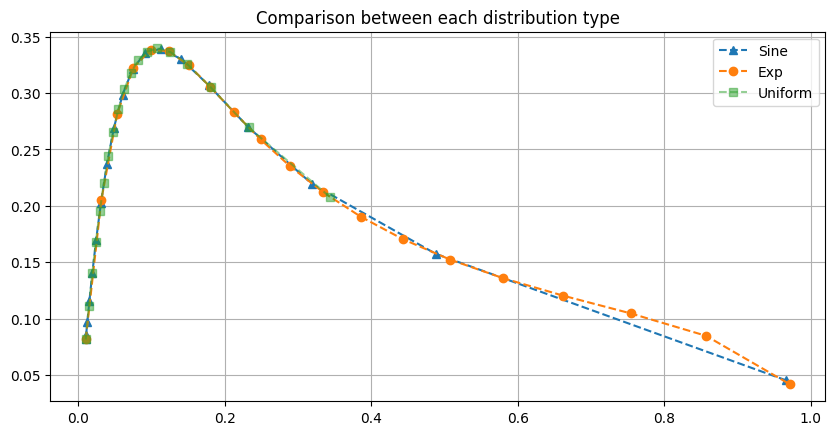

In [8]:
df1 = blade_design('s834', 7, 2, number_of_sections=20,plot=False)
df2 = blade_design('s834', 7, 2, number_of_sections=20, section_distribution='sine', plot=False)
df3 = blade_design('s834', 7, 2, number_of_sections=20, section_distribution='exp', plot=True)

# %% Comparison between each distribution type
plt.figure(figsize=[10, 4.8])

plt.plot(df2['r/R'],df2['c/R']*df2['Tip Correction'], '^--',label = 'Sine')
plt.plot(df3['r/R'],df3['c/R']*df3['Tip Correction'], 'o--',label = 'Exp')
plt.plot(df1['r/R'],df1['c/R']*df1['Tip Correction'], 's--',alpha = 0.5, label = 'Uniform')

plt.title('Comparison between each distribution type')

plt.grid()
plt.legend()
plt.show()

In [9]:
df3

,a,a_line,x,r/R,phi,theta,sigma,c/R,Ct,Tip Correction
0,0.260000,5.500000,0.073361,0.010480,57.202832,52.002832,2.474325,0.081465,0.622832,1.000000
1,0.276960,1.568239,0.222980,0.031854,51.619885,46.419885,2.050553,0.205205,0.579744,1.000000
2,0.289996,0.812656,0.373865,0.053409,46.333977,41.133977,1.677695,0.281501,0.533872,1.000000
3,0.300016,0.499609,0.529435,0.075634,41.401141,36.201141,1.357540,0.322565,0.486960,1.000000
4,0.307717,0.332870,0.692925,0.098989,36.853969,31.653969,1.088328,0.338453,0.440512,1.000000
5,0.313636,0.232143,0.867525,0.123932,32.705024,27.505024,0.865893,0.337131,0.395705,0.999999
6,0.318186,0.166609,1.056482,0.150926,28.951170,23.751170,0.684746,0.324671,0.353371,0.999994
7,0.321683,0.121892,1.263184,0.180455,25.577934,20.377934,0.538941,0.305534,0.314030,0.999983
8,0.324371,0.090381,1.491243,0.213035,22.563383,17.363383,0.422677,0.282884,0.277947,0.999958
9,0.326437,0.067666,1.744553,0.249222,19.881252,14.681252,0.330652,0.258885,0.245194,0.999909
